# End-to-End Architecture Performance Comparisons

In [1]:
# System imports
import os
import sys
from time import time as tt

# External imports
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd

from itertools import chain
from itertools import permutations

import torch
from torch_geometric.data import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_scatter import scatter, segment_csr, scatter_add
from torch_geometric.nn.conv import MessagePassing
from torch_cluster import knn_graph, radius_graph
from torch_sparse import SparseTensor
import torch_sparse
import torch_geometric
import torch_geometric.nn as pygnn

import trackml.dataset

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from prepare_utils import prepare_event
from toy_utils import *
from models import *
from trainers import *
%matplotlib inline

# Get rid of RuntimeWarnings, gross
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import wandb
import faiss
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
torch_seed = 0

In [2]:
from apex.parallel import DistributedDataParallel as DDP
from apex.fp16_utils import *
from apex import amp, optimizers

In [10]:
importlib.reload(sys.modules['toy_utils'])
from toy_utils import *

In [10]:
importlib.reload(sys.modules['models'])
from models import *

### Load Graph Data

In [2]:
pt_cut = 0.5
train_number = 1000
test_number = 100
load_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/"
gnn_train_path = os.path.join(load_dir, str(pt_cut) + "_pt_cut", str(train_number) + "_graphs_train")
gnn_test_path = os.path.join(load_dir, str(pt_cut) + "_pt_cut", str(test_number) + "_graphs_test")

In [3]:
%%time
gnn_train_dataset = torch.load(gnn_train_path)
gnn_test_dataset = torch.load(gnn_test_path)
gnn_train_loader = DataLoader(gnn_train_dataset, batch_size=1, shuffle=True)
gnn_test_loader = DataLoader(gnn_test_dataset, batch_size=1, shuffle=True)

CPU times: user 154 ms, sys: 3.21 s, total: 3.36 s
Wall time: 4.06 s


### Train

New model:

In [13]:
m_configs = {"in_channels": 3, "hidden_dim": 64, "n_graph_iters": 6}
torch.manual_seed(torch_seed)
model = ResAGNN(**m_configs).to(device)
other_configs = {"weight": 2}
m_configs.update(other_configs)
model_name = wandb.init(project="GravNet", group="ResAGNN", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


...or load model:

In [14]:
m_configs = {"in_channels": 3, "hidden_dim": 64, "n_graph_iters": 6}
torch.manual_seed(torch_seed)
model = ResAGNN(**m_configs).to(device)
other_configs = {"weight": 2}
m_configs.update(other_configs)
checkpoint = torch.load('../model_comparisons/ResAGNN/ethereal-wood-503.tar')
model.load_state_dict(checkpoint['model_state_dict'])
model_name = wandb.init(project="GravNet", group="ResAGNN", config=m_configs)
wandb.watch(model, log='all')

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [16]:
for epoch in range(100):
    tic = tt()  
    model.train()
    acc, train_loss = train_gnn(model, gnn_train_loader, optimizer, m_configs)
    print("Training loss:", train_loss)

    model.eval()
    with torch.no_grad():
        acc, eff, pur, val_loss = evaluate_gnn(model, gnn_test_loader, m_configs)
    scheduler.step(val_loss)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "val_acc": acc, "val_pur": pur, "val_eff": eff, "lr": scheduler._last_lr[0]})

    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'ResAGNN/'+model_name._name+'.tar')

    print('Epoch: {}, Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, acc, pur, eff, val_loss, scheduler._last_lr[0], tt()-tic))

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training loss: 25.063142077997327
Epoch: 0, Accuracy: 0.9929, Purity: 0.9604, Efficiency: 0.9898, Loss: 2.3208, LR: 0.001 in time 211.51566171646118
Training loss: 24.163852674886584
Epoch: 1, Accuracy: 0.9930, Purity: 0.9612, Efficiency: 0.9890, Loss: 2.3506, LR: 0.001 in time 211.6275191307068
Training loss: 23.775235688313842
Epoch: 2, Accuracy: 0.9937, Purity: 0.9663, Efficiency: 0.9894, Loss: 2.1385, LR: 0.001 in time 211.61263060569763
Training loss: 23.52497413009405
Epoch: 3, Accuracy: 0.9879, Purity: 0.9304, Efficiency: 0.9864, Loss: 3.7791, LR: 0.001 in time 211.66961789131165
Training loss: 23.31285702250898
Epoch: 4, Accuracy: 0.9931, Purity: 0.9628, Efficiency: 0.9884, Loss: 2.3456, LR: 0.001 in time 211.37088584899902
Training loss: 23.0078675923869
Epoch: 5, Accuracy: 0.9938, Purity: 0.9652, Efficiency: 0.9910, Loss: 2.0477, LR: 0.001 in time 211.63346529006958
Training loss: 22.563860021531582
Epoch: 6, Accuracy: 0.9934, Purity: 0.9631, Efficiency: 0.9901, Loss: 2.2067,

KeyboardInterrupt: 

Error in callback <function _init_jupyter.<locals>.cleanup at 0x2aab7fe45d40> (for post_run_cell):


KeyboardInterrupt: 

### ROC Results

In [17]:
model.eval()

total_pred = []
total_y = []

for batch in gnn_test_loader:
    data = batch.to(device)
    with torch.no_grad():
        pred = model(data)   
    y = batch.pid[batch.e[0]] == batch.pid[batch.e[1]]

    total_pred += pred.detach().cpu().numpy().tolist()
    total_y += y.cpu().numpy().tolist()

In [18]:
fpr, tpr, _ = metrics.roc_curve(total_y, total_pred)

Text(0.5, 1.0, 'AGNN over Biadjacent Embedding')

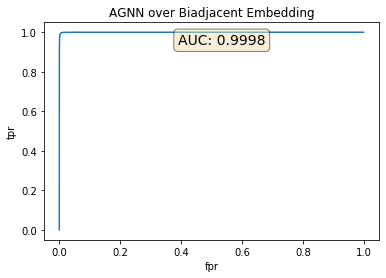

In [19]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.text(0.4, 0.95, "AUC: {:.4f}".format(metrics.roc_auc_score(total_y, total_pred)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("fpr"), ax.set_ylabel("tpr")
ax.set_title("AGNN over Biadjacent Embedding")

Text(0.5, 1.0, 'AGNN over Biadjacent Embedding')

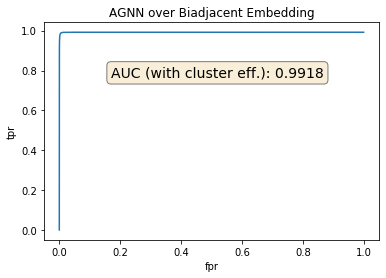

In [20]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr*cluster_eff)
ax.text(0.2, 0.8, "AUC (with cluster eff.): {:.4f}".format(metrics.roc_auc_score(total_y, total_pred)*cluster_eff), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("fpr"), ax.set_ylabel("tpr")
ax.set_title("AGNN over Biadjacent Embedding")

### F1 Results

In [124]:
thresh = 0.4
list(zip(fpr[(fpr) > thresh], tpr[fpr > thresh]))

[(0.4455550437586366, 0.9999556613115385),
 (0.445601105481345, 0.9999556613115385),
 (0.45520497466605253, 0.9999556613115385),
 (0.45525103638876097, 0.9999556613115385),
 (0.45794564716720404, 0.9999556613115385),
 (0.4579917088899125, 0.9999556613115385),
 (0.46722708429295257, 0.9999556613115385),
 (0.467273146015661, 0.9999556613115385),
 (0.48224320589590053, 0.9999556613115385),
 (0.48224320589590053, 0.9999704408743589),
 (0.4847305389221557, 0.9999704408743589),
 (0.4847766006448641, 0.9999704408743589),
 (0.49456471672040536, 0.9999704408743589),
 (0.4946107784431138, 0.9999704408743589),
 (0.5251497005988024, 0.9999704408743589),
 (0.5251957623215108, 0.9999704408743589),
 (0.5346614463380931, 0.9999704408743589),
 (0.5347075080608015, 0.9999704408743589),
 (0.5854905573468447, 0.9999704408743589),
 (0.5855366190695532, 0.9999704408743589),
 (0.5894288346384154, 0.9999704408743589),
 (0.5894748963611239, 0.9999704408743589),
 (0.5923767848917549, 0.9999704408743589),
 (0.59

In [21]:
model.eval()

total_pred = []
total_y = []

for batch in gnn_test_loader:
    data = batch.to(device)
    with torch.no_grad():
        pred = model(data)   
    y = batch.pid[batch.e[0]] == batch.pid[batch.e[1]]

    total_pred += sig(pred).detach().cpu().numpy().tolist()
    total_y += y.cpu().numpy().tolist()

Text(0.5, 1.0, 'GNN on Biadjacent Embedding')

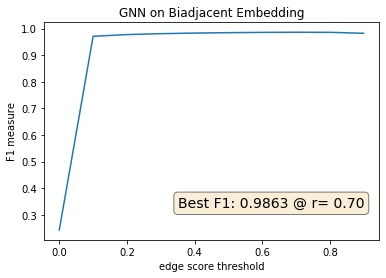

In [27]:
fig, ax = plt.subplots()
f1 = [metrics.f1_score(total_y, np.array(total_pred)>thresh) for thresh in np.arange(0,1,0.1)]
ax.plot(np.arange(0,1,0.1), f1)
ax.text(0.4, 0.2, "Best F1: {:.4f} @ r= {:.2f}".format(max(f1), 0.1*np.argmax(f1)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("edge score threshold"), ax.set_ylabel("F1 measure")
ax.set_title("GNN on Biadjacent Embedding")

## Scatter-Gather PyG Original Representation

In [52]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation='Tanh',
                 layer_norm=True):
        super(EdgeNetwork, self).__init__()
        self.network = make_mlp(input_dim*2,
                                [hidden_dim, hidden_dim, hidden_dim, 1],
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, x, edge_index):
        # Select the features of the associated nodes
        start, end = edge_index
        x1, x2 = x[start], x[end]
        edge_inputs = torch.cat([x[start], x[end]], dim=1)
        return self.network(edge_inputs).squeeze(-1)

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation='Tanh',
                 layer_norm=True):
        super(NodeNetwork, self).__init__()
        self.network = make_mlp(input_dim*3, [output_dim]*4,
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, x, e, edge_index):
        start, end = edge_index
        # Aggregate edge-weighted incoming/outgoing features
        mi = scatter_add(e[:, None] * x[start], end, dim=0, dim_size=x.shape[0])
        mo = scatter_add(e[:, None] * x[end], start, dim=0, dim_size=x.shape[0])
        node_inputs = torch.cat([mi, mo, x], dim=1)
        return self.network(node_inputs)
    
class GATGNN(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, in_channels=3, hidden_dim=8, n_graph_iters=3,
                 hidden_activation=torch.nn.Tanh, layer_norm=True):
        super(GATGNN, self).__init__()
        self.n_graph_iters = n_graph_iters
        # Setup the input network
        self.input_network = make_mlp(in_channels, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        # Setup the edge network
        self.edge_network = EdgeNetwork(in_channels + hidden_dim, in_channels + hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = NodeNetwork(in_channels + hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        
    def forward(self, x, edge_index):
        """Apply forward pass of the model"""
        x_in = x
        x = self.input_network(x)
        # Shortcut connect the inputs onto the hidden representation
        x = torch.cat([x, x_in], dim=-1)
#         print(x.shape)
        
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            x_inital = x
            
            # Apply edge network
            e = torch.sigmoid(self.edge_network(x, edge_index))
        
            # Apply node network
            x = self.node_network(x, e, edge_index)
            
            # Shortcut connect the inputs onto the hidden representation
            x = torch.cat([x, x_in], dim=-1)  
            
            x = x_inital + x
        
        return self.edge_network(x, edge_index)

In [53]:
def train_gnn(model, gnn_train_loader, optimizer, m_configs):
    correct = 0
    total = 0
    total_loss = 0
    data_time, pred_time, loss_time, loss_back_time, optimizer_step = 0, 0, 0, 0, 0
    for i, batch in enumerate(gnn_train_loader):
        optimizer.zero_grad()
        tic = tt()
        data = batch.to(device)
        data_time += tt()-tic
        tic = tt()
        pred = model(data.x, data.edge_index)
        pred_time += tt()-tic
        
        y = batch.y
        tic = tt()
        loss = F.binary_cross_entropy_with_logits(pred.float(), y, pos_weight=torch.tensor(m_configs["weight"]))
        loss_time += tt()-tic
        tic = tt()
        loss.backward()
        loss_back_time += tt()-tic
        tic = tt()
        optimizer.step()
        optimizer_step += tt()-tic
        
        total_loss += loss.item()

        true, false = y.float() > 0.5, y.float() < 0.5
        positive, negative = sig(pred) > 0.5, sig(pred) < 0.5

        correct += ((sig(pred) > 0.5) == (y.float() > 0.5)).sum().item()
        total += len(pred)
        if(i%200==0): print(i, "batches")
        
    acc = correct/max(total, 1)
    print("data_time, pred_time, loss_time, loss_back_time, optimizer_step")
    print(data_time, pred_time, loss_time, loss_back_time, optimizer_step)
    return acc, total_loss

def evaluate_gnn(model, gnn_test_loader, m_configs):
    correct, total_positive, total_true, true_positive, total, total_loss = 0, 1, 0, 0, 0, 0
    
    for batch in gnn_test_loader:
        data = batch.to(device)
#         pred = model(data.x, data.edge_index.int())
        pred = model(data.x, data.edge_index)
              
        y = batch.y
        loss = F.binary_cross_entropy_with_logits(pred.float(), y.float(), pos_weight=torch.tensor(m_configs["weight"]))
        total_loss += loss.item()

        true, false = y.float() > 0.5, y.float() < 0.5
        positive, negative = sig(pred) > 0.5, sig(pred) < 0.5
        true_positive += (true & positive).sum().item()
        total_positive += max(positive.sum().item(), 1)

        correct += ((sig(pred) > 0.5) == (y.float() > 0.5)).sum().item()
        total_true += max(true.sum().item(), 1)
        total += len(pred)

    acc = correct/max(total, 1)
    eff = (true_positive / max(total_true, 1))
    pur = (true_positive / max(total_positive, 1))
     
    return acc, eff, pur, total_loss

In [57]:
m_configs = {"in_channels": 3, "hidden_dim": 32, "n_graph_iters": 8}
model = GATGNN(**m_configs).to(device)
other_configs = {"weight": 3}
torch.manual_seed(torch_seed)
m_configs.update(other_configs)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
# optimizer = optimizers.FusedAdam(model.parameters(), lr = 0.001, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)
torch.cuda.reset_max_memory_cached(device=device)

In [58]:
for epoch in range(10):
    tic = tt()  
    model.train()
    acc, train_loss = train_gnn(model, gnn_train_loader, optimizer, m_configs)
    print("Training loss:", train_loss)

    model.eval()
    with torch.no_grad():
        acc, eff, pur, val_loss = evaluate_gnn(model, gnn_test_loader, m_configs)
    scheduler.step(val_loss)
#     wandb.log({"val_loss": val_loss, "train_loss": train_loss, "val_acc": acc, "val_pur": pur, "val_eff": eff, "lr": scheduler._last_lr[0]})

#     save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'ResAGNN/'+model_name._name+'.tar')
    print("End of epoch mem:", torch.cuda.memory_allocated(device=device)/(1024**2), "MB")
    print('Epoch: {}, Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, acc, pur, eff, val_loss, scheduler._last_lr[0], tt()-tic))

0 batches
200 batches
400 batches
600 batches
800 batches
data_time, pred_time, loss_time, loss_back_time, optimizer_step
1.9896533489227295 13.077362775802612 0.39206933975219727 181.28339552879333 4.446962356567383
Training loss: 340.7721998691559
End of epoch mem: 6.1396484375 MB
Epoch: 0, Accuracy: 0.9348, Purity: 0.6970, Efficiency: 0.9367, Loss: 19.7048, LR: 0.001 in time 208.73812127113342
0 batches
200 batches
600 batches
800 batches
data_time, pred_time, loss_time, loss_back_time, optimizer_step
1.9938678741455078 12.994366645812988 0.39365077018737793 181.22496461868286 4.3604230880737305
Training loss: 181.9768833965063
End of epoch mem: 6.1396484375 MB
Epoch: 1, Accuracy: 0.9377, Purity: 0.7030, Efficiency: 0.9527, Loss: 17.9121, LR: 0.001 in time 208.51447772979736
0 batches
200 batches
400 batches
600 batches
800 batches
data_time, pred_time, loss_time, loss_back_time, optimizer_step
1.998703956604004 12.937515497207642 0.3961021900177002 181.26568222045898 4.330440521240

KeyboardInterrupt: 

In [143]:
print(torch.cuda.memory_summary(device=device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1704 MB |    2364 MB |  110892 GB |  110890 GB |
|---------------------------------------------------------------------------|
| Active memory         |    1704 MB |    2364 MB |  110892 GB |  110890 GB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |   10120 MB |   10120 MB |   10120 MB |       0 B  |
|---------------------------------------------------------------

## Scatter-Gather PyG Representation

In [48]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation='Tanh',
                 layer_norm=True):
        super(EdgeNetwork, self).__init__()
        self.network = make_mlp(input_dim*2,
                                [hidden_dim, hidden_dim, hidden_dim, 1],
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, x, edge_index):
        # Select the features of the associated nodes
        start, end = edge_index
        x1, x2 = x[start], x[end]
        edge_inputs = torch.cat([x[start], x[end]], dim=1)
        return self.network(edge_inputs).squeeze(-1)

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation='Tanh',
                 layer_norm=True):
        super(NodeNetwork, self).__init__()
        self.network = make_mlp(input_dim*3, [output_dim]*4,
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, x, e, edge_index):
        start, end = edge_index
        # Aggregate edge-weighted incoming/outgoing features
        mi = scatter_add(e[:, None] * x[start], end, dim=0, dim_size=x.shape[0])
        mo = scatter_add(e[:, None] * x[end], start, dim=0, dim_size=x.shape[0])
        node_inputs = torch.cat([mi, mo, x], dim=1)
        return self.network(node_inputs)
    
class GATGNN(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, in_channels=3, hidden_dim=8, n_graph_iters=3,
                 hidden_activation=torch.nn.Tanh, layer_norm=True):
        super(GATGNN, self).__init__()
        self.n_graph_iters = n_graph_iters
        # Setup the input network
        self.input_network = make_mlp(in_channels, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        
        self.GATConv = pygnn.GATConv(hidden_dim, hidden_dim)
        
        # Setup the node layers
        self.node_network = make_mlp(hidden_dim,
                                        [hidden_dim]*4,
                                        output_activation=None,
                                           layer_norm=layer_norm)
        
        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_dim,
                                        [hidden_dim, hidden_dim, hidden_dim, 1],
                                        output_activation=None)
        
    def forward(self, x, edge_index):
        """Apply forward pass of the model"""

        x = self.input_network(x)

        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            x_inital = x
            
            # Apply edge network
            x = self.GATConv(x, edge_index)
            x = self.node_network(x)
            
            x = x_inital + x        
    
        start_idx, end_idx = edge_index
        return self.edge_classifier(torch.cat([x[start_idx], x[end_idx]], dim=1)).squeeze(-1)

In [49]:
def train_gnn(model, gnn_train_loader, optimizer, m_configs):
    correct = 0
    total = 0
    total_loss = 0
    data_time, pred_time, loss_time, loss_back_time, optimizer_step = 0, 0, 0, 0, 0
    for i, batch in enumerate(gnn_train_loader):
        optimizer.zero_grad()
        tic = tt()
        data = batch.to(device)
        data_time += tt()-tic
#         print("Edge float", data.e.max().item(), data.e)
#         print("Edge long", data.e.long().max().item(), data.e.long())
#         print("Edge shape", data.e.shape)
        
#         pred = model(data.x, data.edge_index.int())
        tic = tt()
        pred = model(data.x, data.edge_index)
        pred_time += tt()-tic
        
        y = batch.y
#         print("y", np.isnan(y.cpu().detach().numpy()).sum())
#         if (np.isnan(pred.cpu().detach().numpy()).sum() == 0):
        tic = tt()
        loss = F.binary_cross_entropy_with_logits(pred.float(), y, pos_weight=torch.tensor(m_configs["weight"]))
        loss_time += tt()-tic
#         with amp.scale_loss(loss, optimizer) as scaled_loss:
#             scaled_loss.backward()
        tic = tt()
        loss.backward()
        loss_back_time += tt()-tic
#         torch.nn.utils.clip_grad_norm_(model.parameters(), m_configs["clip"])
        tic = tt()
        optimizer.step()
        optimizer_step += tt()-tic
        
        total_loss += loss.item()

        true, false = y.float() > 0.5, y.float() < 0.5
        positive, negative = sig(pred) > 0.5, sig(pred) < 0.5

        correct += ((sig(pred) > 0.5) == (y.float() > 0.5)).sum().item()
        total += len(pred)
#         else:
#             print("Broke!")
        if(i%200==0): print(i, "batches")
        
    acc = correct/max(total, 1)
    print("data_time, pred_time, loss_time, loss_back_time, optimizer_step")
    print(data_time, pred_time, loss_time, loss_back_time, optimizer_step)
    return acc, total_loss

def evaluate_gnn(model, gnn_test_loader, m_configs):
    correct, total_positive, total_true, true_positive, total, total_loss = 0, 1, 0, 0, 0, 0
    
    for batch in gnn_test_loader:
        data = batch.to(device)
#         pred = model(data.x, data.edge_index.int())
        pred = model(data.x, data.edge_index)
              
        y = batch.y

#         print("y", y, "length", len(y))
#         if (np.isnan(pred.cpu().detach().numpy()).sum() == 0):
        loss = F.binary_cross_entropy_with_logits(pred.float(), y.float(), pos_weight=torch.tensor(m_configs["weight"]))
        total_loss += loss.item()

        true, false = y.float() > 0.5, y.float() < 0.5
#         print("true", true, "sum", true.float().sum().item())
        positive, negative = sig(pred) > 0.5, sig(pred) < 0.5
        true_positive += (true & positive).sum().item()
        total_positive += max(positive.sum().item(), 1)

        correct += ((sig(pred) > 0.5) == (y.float() > 0.5)).sum().item()
        total_true += max(true.sum().item(), 1)

#         print("True positive:", (true & positive).sum().item(), "True:", true.sum().item(), "Positive", positive.sum().item())

        total += len(pred)

    acc = correct/max(total, 1)
    eff = (true_positive / max(total_true, 1))
    pur = (true_positive / max(total_positive, 1))
    
#     print("Num total_true:", total_true, "Num total_positive:", total_positive, "Num true_positive:", true_positive, "Total edges:", total)
        
    return acc, eff, pur, total_loss

In [50]:
m_configs = {"in_channels": 3, "hidden_dim": 32, "n_graph_iters": 8}
model = GATGNN(**m_configs).to(device)
other_configs = {"weight": 3}
torch.manual_seed(torch_seed)
m_configs.update(other_configs)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
# optimizer = optimizers.FusedAdam(model.parameters(), lr = 0.001, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)

In [51]:
for epoch in range(10):
    tic = tt()  
    model.train()
    acc, train_loss = train_gnn(model, gnn_train_loader, optimizer, m_configs)
    print("Training loss:", train_loss)

    model.eval()
    with torch.no_grad():
        acc, eff, pur, val_loss = evaluate_gnn(model, gnn_test_loader, m_configs)
    scheduler.step(val_loss)
#     wandb.log({"val_loss": val_loss, "train_loss": train_loss, "val_acc": acc, "val_pur": pur, "val_eff": eff, "lr": scheduler._last_lr[0]})

#     save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'ResAGNN/'+model_name._name+'.tar')
    print("End of epoch mem:", torch.cuda.memory_allocated(device=device)/(1024**2), "MB")
    print('Epoch: {}, Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, acc, pur, eff, val_loss, scheduler._last_lr[0], tt()-tic))

0 batches
200 batches
400 batches
600 batches
800 batches
data_time, pred_time, loss_time, loss_back_time, optimizer_step
1.820138931274414 12.623053789138794 0.35951733589172363 28.219863653182983 3.8809192180633545
Training loss: 758.5221596360207
End of epoch mem: 97.51318359375 MB
Epoch: 0, Accuracy: 0.8217, Purity: 0.2654, Efficiency: 0.1629, Loss: 72.1881, LR: 0.001 in time 51.52574038505554
0 batches
200 batches
400 batches
600 batches
800 batches
data_time, pred_time, loss_time, loss_back_time, optimizer_step
1.8527512550354004 12.566985368728638 0.3548462390899658 28.18063735961914 3.8620123863220215
Training loss: 691.3220467567444
End of epoch mem: 97.51318359375 MB
Epoch: 1, Accuracy: 0.7814, Purity: 0.3583, Efficiency: 0.7312, Loss: 57.0352, LR: 0.001 in time 51.51437950134277
0 batches
200 batches
400 batches
600 batches
800 batches
data_time, pred_time, loss_time, loss_back_time, optimizer_step
1.8375728130340576 12.673328638076782 0.3487412929534912 28.170597314834595 3

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/global/homes/d/danieltm/.conda/envs/latest-pyg/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-51-419928ee1b43>", line 4, in <module>
    acc, train_loss = train_gnn(model, gnn_train_loader, optimizer, m_configs)
  File "<ipython-input-49-31d20dfeaaf0>", line 29, in train_gnn
    loss.backward()
  File "/global/homes/d/danieltm/.conda/envs/latest-pyg/lib/python3.8/site-packages/torch/tensor.py", line 198, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph)
  File "/global/homes/d/danieltm/.conda/envs/latest-pyg/lib/python3.8/site-packages/torch/autograd/__init__.py", line 98, in backward
    Variable._execution_engine.run_backward(
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/global/homes/d/danieltm/.conda/envs/l

TypeError: object of type 'NoneType' has no len()

### Memory Report

In [38]:
print(torch.cuda.memory_summary(device=device, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    4927 KB |  754480 KB |   21728 GB |   21728 GB |
|       from large pool |    2847 KB |  748023 KB |   19646 GB |   19646 GB |
|       from small pool |    2080 KB |   46028 KB |    2081 GB |    2081 GB |
|---------------------------------------------------------------------------|
| Active memory         |    4927 KB |  754480 KB |   21728 GB |   21728 GB |
|       from large pool |    2847 KB |  748023 KB |   19646 GB |

In [62]:
torch.cuda.reset_max_memory_cached(device=device)

In [14]:
# torch.cuda.empty_cache()
print(torch.cuda.memory_allocated(device=device)/(1024**2), "MB")

0.0 MB


### Test Batch Memory

In [10]:
def fix_y_batch(batch):
    
    data = Data(x = batch.x, y = batch.y, edge_index = batch.e.long())
    
    return data

In [11]:
%%time
gnn_train_dataset_fix = [fix_y_batch(batch) for batch in gnn_train_dataset]
gnn_test_dataset_fix = [fix_y_batch(batch) for batch in gnn_test_dataset]

CPU times: user 607 ms, sys: 1.33 s, total: 1.94 s
Wall time: 1.07 s


In [12]:
%%time
gnn_train_loader = DataLoader(gnn_train_dataset_fix, batch_size=1, shuffle=False, num_workers=1)
gnn_test_loader = DataLoader(gnn_test_dataset_fix, batch_size=1, shuffle=False, num_workers=1)

CPU times: user 87 µs, sys: 0 ns, total: 87 µs
Wall time: 89.9 µs


In [27]:
%%time
model.eval()
with torch.no_grad():
    for i, batch in enumerate(gnn_train_loader):            
#             print(batch)
            data = batch.to(device)
            pred = model(data.x, data.edge_index.int())
            if(i%100==0): print(i, "samples evaluated")

0 samples evaluated
CPU times: user 31.3 s, sys: 11.4 s, total: 42.7 s
Wall time: 43.7 s


## Scatter-Gather Built-in PyG Representation

In [127]:
class GATGNN(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, in_channels=3, hidden_dim=8, n_graph_iters=3,
                 hidden_activation=torch.nn.Tanh, layer_norm=True):
        super(GATGNN, self).__init__()
        self.n_graph_iters = n_graph_iters
        # Setup the input network
        self.input_network = make_mlp(in_channels, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        
        self.GATConv = pygnn.GATConv(hidden_dim, hidden_dim, add_self_loops=True)
        
        # Setup the node layers
        self.node_network = node_network = make_mlp(hidden_dim,
                                        [hidden_dim]*2,
                                        output_activation=None,
                                           layer_norm=layer_norm)
        
        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_dim,
                                        [hidden_dim, 1],
                                        output_activation=None)
        
    def forward(self, x, edge_index):
        """Apply forward pass of the model"""

        x_in = x
        x = self.input_network(x)

        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            x_inital = x
            
            # Apply edge network
            x = self.GATConv(x, edge_index)
            x = self.node_network(x)
            
            x = x_inital + x        
    
        _, weights = self.GATConv(x, edge_index, return_attention_weights=True)
        
        return weights[0], weights[1].squeeze(-1)

In [140]:
def train_gnn(model, gnn_train_loader, optimizer, m_configs):
    correct = 0
    total = 0
    total_loss = 0
    data_time, pred_time, loss_time, loss_back_time, optimizer_step = 0, 0, 0, 0, 0
    for i, batch in enumerate(gnn_train_loader):
        optimizer.zero_grad()
        tic = tt()
        data = batch.to(device)
        data_time += tt()-tic
#         print("Edge float", data.e.max().item(), data.e)
#         print("Edge long", data.e.long().max().item(), data.e.long())
#         print("Edge shape", data.e.shape)
        
#         pred = model(data.x, data.edge_index.int())
        tic = tt()
        edges, pred = model(data.x, data.edge_index)
        pred_time += tt()-tic
        
        pred = pred[edges[0] != edges[1]]
        edges = edges[:, edges[0] != edges[1]]
        y = batch.y
        

#         print(edges.shape, pred.shape, data.edge_index.shape, y.shape)
        weight = y + (y==0).float()*(1/m_configs["weight"])
#         print(weight)
        
        tic = tt()
        loss = F.binary_cross_entropy(pred.float(), y, weight=weight)
        loss_time += tt()-tic
        tic = tt()
        loss.backward()
        loss_back_time += tt()-tic
        tic = tt()
        optimizer.step()
        optimizer_step += tt()-tic
        
        total_loss += loss.item()

        true, false = y.float() > 0.5, y.float() < 0.5
        positive, negative = pred > 0.5, pred < 0.5

        correct += ((pred > 0.5) == (y.float() > 0.5)).sum().item()
        total += len(pred)
#         else:
#             print("Broke!")
        if(i%200==0): print(i, "batches")
        
    acc = correct/max(total, 1)
    print("data_time, pred_time, loss_time, loss_back_time, optimizer_step")
    print(data_time, pred_time, loss_time, loss_back_time, optimizer_step)
    return acc, total_loss

def evaluate_gnn(model, gnn_test_loader, m_configs):
    correct, total_positive, total_true, true_positive, total, total_loss = 0, 1, 0, 0, 0, 0
    
    for batch in gnn_test_loader:
        data = batch.to(device)
#         pred = model(data.x, data.edge_index.int())
        edges, pred = model(data.x, data.edge_index)
        pred = pred[edges[0] != edges[1]]
        edges = edges[:, edges[0] != edges[1]]
        y = batch.y

#         print("y", y, "length", len(y))
#         if (np.isnan(pred.cpu().detach().numpy()).sum() == 0):
        weight = y + (y==0).float()*(1/m_configs["weight"])
        loss = F.binary_cross_entropy(pred.float(), y, weight=weight)
        total_loss += loss.item()

        true, false = y.float() > 0.5, y.float() < 0.5
#         print("true", true, "sum", true.float().sum().item())
        positive, negative = pred > 0.5, pred < 0.5
        true_positive += (true & positive).sum().item()
        total_positive += max(positive.sum().item(), 1)

        correct += ((pred > 0.5) == (y.float() > 0.5)).sum().item()
        total_true += max(true.sum().item(), 1)

#         print("True positive:", (true & positive).sum().item(), "True:", true.sum().item(), "Positive", positive.sum().item())

        total += len(pred)

    acc = correct/max(total, 1)
    eff = (true_positive / max(total_true, 1))
    pur = (true_positive / max(total_positive, 1))
    
#     print("Num total_true:", total_true, "Num total_positive:", total_positive, "Num true_positive:", true_positive, "Total edges:", total)
        
    return acc, eff, pur, total_loss

In [141]:
m_configs = {"in_channels": 3, "hidden_dim": 32, "n_graph_iters": 8}
model = GATGNN(**m_configs).to(device)
other_configs = {"weight": 3}
torch.manual_seed(torch_seed)
m_configs.update(other_configs)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
# optimizer = optimizers.FusedAdam(model.parameters(), lr = 0.001, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)
torch.cuda.reset_max_memory_cached(device=device)

In [142]:
for epoch in range(10):
    tic = tt()  
    model.train()
    acc, train_loss = train_gnn(model, gnn_train_loader, optimizer, m_configs)
    print("Training loss:", train_loss)

    model.eval()
    with torch.no_grad():
        acc, eff, pur, val_loss = evaluate_gnn(model, gnn_test_loader, m_configs)
    scheduler.step(val_loss)
#     wandb.log({"val_loss": val_loss, "train_loss": train_loss, "val_acc": acc, "val_pur": pur, "val_eff": eff, "lr": scheduler._last_lr[0]})

#     save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'ResAGNN/'+model_name._name+'.tar')
    print("End of epoch mem:", torch.cuda.memory_allocated(device=device)/(1024**2), "MB")
    print('Epoch: {}, Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, acc, pur, eff, val_loss, scheduler._last_lr[0], tt()-tic))

0 batches
200 batches
400 batches
600 batches
800 batches
data_time, pred_time, loss_time, loss_back_time, optimizer_step
1.8630015850067139 11.298678159713745 0.16671490669250488 17.794898748397827 1.762826919555664
Training loss: 321.11012029647827
End of epoch mem: 1693.509765625 MB
Epoch: 0, Accuracy: 0.8618, Purity: 0.5254, Efficiency: 0.0187, Loss: 32.1886, LR: 0.001 in time 37.27451252937317
0 batches
200 batches
400 batches
600 batches
800 batches
data_time, pred_time, loss_time, loss_back_time, optimizer_step
1.9733922481536865 11.325664520263672 0.1690375804901123 17.76284694671631 1.7714216709136963
Training loss: 319.9882273674011
End of epoch mem: 1693.509765625 MB
Epoch: 1, Accuracy: 0.8618, Purity: 0.5276, Efficiency: 0.0190, Loss: 32.1732, LR: 0.001 in time 37.467103242874146
0 batches
200 batches
400 batches
600 batches
800 batches
data_time, pred_time, loss_time, loss_back_time, optimizer_step
1.9007835388183594 11.335787534713745 0.1678924560546875 17.780579328536987

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2aab21f61280>
Traceback (most recent call last):
  File "/global/homes/d/danieltm/.conda/envs/latest-pyg/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/global/homes/d/danieltm/.conda/envs/latest-pyg/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/global/homes/d/danieltm/.conda/envs/latest-pyg/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/global/homes/d/danieltm/.conda/envs/latest-pyg/lib/python3.8/multiprocessing/popen_fork.py", line 47, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/global/homes/d/danieltm/.conda/envs/latest-pyg/lib/python3.8/multiprocessing/popen_fork.py", line 27, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


KeyboardInterrupt: 

## Sparse PyG Representation

In [6]:
def fix_y_batch(batch):
    
    data = Data(x = batch.x, y = batch.y, edge_index = batch.e.long())
    
    return data

In [7]:
%%time
gnn_train_dataset_fix = [fix_y_batch(batch) for batch in gnn_train_dataset]
gnn_test_dataset_fix = [fix_y_batch(batch) for batch in gnn_test_dataset]

CPU times: user 640 ms, sys: 1.26 s, total: 1.9 s
Wall time: 994 ms


In [8]:
%%time
gnn_train_loader = DataLoader(gnn_train_dataset_fix, batch_size=1, shuffle=False, num_workers=1)
gnn_test_loader = DataLoader(gnn_test_dataset_fix, batch_size=1, shuffle=False, num_workers=1)

CPU times: user 70 µs, sys: 0 ns, total: 70 µs
Wall time: 73 µs


In [13]:
def add_sparse(batch):
    e = batch.e.long()
    data = Data(x = batch.x, y = batch.y, edge_index = e, adj_t = SparseTensor(row=e[0], col=e[1]).t())
    
    return data

In [27]:
def add_sparse(batch):
    
    data = Data(x = batch.x, y = batch.y, edge_index = batch.e.long(), 
                adj_t = SparseTensor(row=batch.e.long()[0], col=batch.e.long()[1], sparse_sizes=(len(batch.x), len(batch.x))).t())
    
    return data

In [28]:
%%time
gnn_train_dataset_fix = [add_sparse(batch) for batch in gnn_train_dataset]
gnn_test_dataset_fix = [add_sparse(batch) for batch in gnn_test_dataset]

CPU times: user 1min 2s, sys: 13.9 s, total: 1min 15s
Wall time: 56 s


In [29]:
%%time
gnn_train_loader = DataLoader(gnn_train_dataset_fix, batch_size=1, shuffle=False, num_workers=1)
gnn_test_loader = DataLoader(gnn_test_dataset_fix, batch_size=1, shuffle=False, num_workers=1)

CPU times: user 24.6 ms, sys: 26.4 ms, total: 50.9 ms
Wall time: 461 ms


In [64]:
def train_gnn(model, gnn_train_loader, optimizer, m_configs):
    correct = 0
    total = 0
    total_loss = 0
    data_time, pred_time, loss_time, loss_back_time, optimizer_step = 0, 0, 0, 0, 0
    for i, batch in enumerate(gnn_train_loader):
        optimizer.zero_grad()
        tic = tt()
        data = batch.to(device)
        data_time += tt()-tic
#         print("Edge float", data.e.max().item(), data.e)
#         print("Edge long", data.e.long().max().item(), data.e.long())
#         print("Edge shape", data.e.shape)
        
#         pred = model(data.x, data.edge_index.int())
        tic = tt()
#         pred = model(data.x, data.edge_index)
        pred = model(data.x, data.adj_t, data.edge_index)
        pred_time += tt()-tic
#         print("Pred type", pred.type())
        y = batch.y
#         print("y", np.isnan(y.cpu().detach().numpy()).sum())
#         if (np.isnan(pred.cpu().detach().numpy()).sum() == 0):
        tic = tt()
        loss = F.binary_cross_entropy_with_logits(pred.float(), y, pos_weight=torch.tensor(m_configs["weight"]))
        loss_time += tt()-tic
        tic = tt()
#         with amp.scale_loss(loss, optimizer) as scaled_loss:
#             scaled_loss.backward()
        loss.backward()
        loss_back_time += tt()-tic
#         torch.nn.utils.clip_grad_norm_(model.parameters(), m_configs["clip"])
        tic = tt()
        optimizer.step()
        optimizer_step += tt()-tic
        
        total_loss += loss.item()

        true, false = y.float() > 0.5, y.float() < 0.5
        positive, negative = sig(pred) > 0.5, sig(pred) < 0.5

        correct += ((sig(pred) > 0.5) == (y.float() > 0.5)).sum().item()
        total += len(pred)
#         else:
#             print("Broke!")
#         if(i%50==0): print(i, "batches")
        
    acc = correct/max(total, 1)
    print("data_time, pred_time, loss_time, loss_back_time, optimizer_step")
    print(data_time, pred_time, loss_time, loss_back_time, optimizer_step)
    return acc, total_loss

def evaluate_gnn(model, gnn_test_loader, m_configs):
    correct, total_positive, total_true, true_positive, total, total_loss = 0, 1, 0, 0, 0, 0
    
    for batch in gnn_test_loader:
        data = batch.to(device)
#         pred = model(data.x, data.edge_index.int())
#         pred = model(data.x, data.edge_index)
        pred = model(data.x, data.adj_t, data.edge_index)
              
        y = batch.y

#         print("y", y, "length", len(y))
#         if (np.isnan(pred.cpu().detach().numpy()).sum() == 0):
        loss = F.binary_cross_entropy_with_logits(pred.float(), y.float(), pos_weight=torch.tensor(m_configs["weight"]))
        total_loss += loss.item()

        true, false = y.float() > 0.5, y.float() < 0.5
#         print("true", true, "sum", true.float().sum().item())
        positive, negative = sig(pred) > 0.5, sig(pred) < 0.5
        true_positive += (true & positive).sum().item()
        total_positive += max(positive.sum().item(), 1)

        correct += ((sig(pred) > 0.5) == (y.float() > 0.5)).sum().item()
        total_true += max(true.sum().item(), 1)

#         print("True positive:", (true & positive).sum().item(), "True:", true.sum().item(), "Positive", positive.sum().item())

        total += len(pred)

    acc = correct/max(total, 1)
    eff = (true_positive / max(total_true, 1))
    pur = (true_positive / max(total_positive, 1))
    
#     print("Num total_true:", total_true, "Num total_positive:", total_positive, "Num true_positive:", true_positive, "Total edges:", total)
        
    return acc, eff, pur, total_loss

In [65]:
class GinGNN(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, in_channels=3, hidden_dim=8, n_graph_iters=3,
                 hidden_activation=torch.nn.Tanh, layer_norm=True):
        super(GinGNN, self).__init__()
        self.n_graph_iters = n_graph_iters
        # Setup the input network
        self.input_network = make_mlp(in_channels, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        
        # Setup the node layers
        node_network = make_mlp(hidden_dim,
                                        [hidden_dim]*2,
                                        output_activation=None,
                                           layer_norm=layer_norm)
        
        # The GIN Conv layer
        self.gin_conv = pygnn.GINConv(nn=node_network)
                
        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_dim,
                                        [hidden_dim, 1],
                                        output_activation=None)
        
    def forward(self, x, adj_t, edge_index):
        
        """Apply forward pass of the model"""
        
        x = self.input_network(x)
        
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            x_inital = x
            
            # Apply GIN Conv
            x = self.gin_conv(x, edge_index)
#             print(x.shape)
#                                 
            x = x_inital + x
#         if type(adj_t) is SparseTensor:
#             end_idx, start_idx, _ = adj_t.coo()
#         else:
        start_idx, end_idx = edge_index
#         clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)
#         print(x.shape)
#         print(clf_inputs.shape)
        return self.edge_classifier(torch.cat([x[start_idx], x[end_idx]], dim=1)).squeeze(-1)

In [66]:
m_configs = {"in_channels": 3, "hidden_dim": 512, "n_graph_iters": 6}
model = GinGNN(**m_configs).to(device)
other_configs = {"weight": 3}
torch.manual_seed(torch_seed)
m_configs.update(other_configs)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
# optimizer = optimizers.FusedAdam(model.parameters(), lr = 0.001, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)

In [67]:
# torch.backends.cudnn.benchmark = True
for epoch in range(100):
    tic = tt()  
    model.train()
    acc, train_loss = train_gnn(model, gnn_train_loader, optimizer, m_configs)
    print("Training loss:", train_loss)

    model.eval()
    with torch.no_grad():
        acc, eff, pur, val_loss = evaluate_gnn(model, gnn_test_loader, m_configs)
    scheduler.step(val_loss)
#     wandb.log({"val_loss": val_loss, "train_loss": train_loss, "val_acc": acc, "val_pur": pur, "val_eff": eff, "lr": scheduler._last_lr[0]})

#     save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'ResAGNN/'+model_name._name+'.tar')
#     print("End of epoch mem:", torch.cuda.memory_allocated(device=device)/(1024**2), "MB")
    print('Epoch: {}, Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, acc, pur, eff, val_loss, scheduler._last_lr[0], tt()-tic))

data_time, pred_time, loss_time, loss_back_time, optimizer_step
4.200277805328369 3.403604030609131 0.29317760467529297 64.32442736625671 1.3901522159576416
Training loss: 744.6156910657883
Epoch: 0, Accuracy: 0.8275, Purity: 0.3730, Efficiency: 0.3615, Loss: 65.1918, LR: 0.001 in time 118.89290928840637


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2aab33250820>
Traceback (most recent call last):
  File "/global/homes/d/danieltm/.conda/envs/latest-pyg/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/global/homes/d/danieltm/.conda/envs/latest-pyg/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/global/homes/d/danieltm/.conda/envs/latest-pyg/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/global/homes/d/danieltm/.conda/envs/latest-pyg/lib/python3.8/multiprocessing/popen_fork.py", line 47, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/global/homes/d/danieltm/.conda/envs/latest-pyg/lib/python3.8/multiprocessing/popen_fork.py", line 27, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


KeyboardInterrupt: 

### Sparse Tensors

In [19]:
%%time
batch = next(iter(gnn_train_loader))
data = batch.to(device)

CPU times: user 10.9 ms, sys: 212 ms, total: 223 ms
Wall time: 687 ms


In [20]:
%%time
x = batch.x
e = batch.edge_index

CPU times: user 19 µs, sys: 3 µs, total: 22 µs
Wall time: 24.3 µs


In [24]:
%%time
num_nodes = len(x)
adj_t = SparseTensor(row=e[0], col=e[1], sparse_sizes=(num_nodes, num_nodes)).t()

CPU times: user 2.68 ms, sys: 434 µs, total: 3.12 ms
Wall time: 3.17 ms


In [25]:
x.shape

torch.Size([22780, 3])

In [26]:
adj_t

SparseTensor(row=tensor([ 4061,  4061,  4061,  ..., 22779, 22779, 22779], device='cuda:0'),
             col=tensor([   88,    98,   110,  ..., 21655, 21656, 21657], device='cuda:0'),
             size=(22780, 22780), nnz=179362, density=0.03%)

In [51]:
start, end, _ = adj_t.t().coo()

In [58]:
start.max()

tensor(21747, device='cuda:0')

In [59]:
adj_t

SparseTensor(row=tensor([ 4061,  4061,  4061,  ..., 22779, 22779, 22779], device='cuda:0'),
             col=tensor([   88,    98,   110,  ..., 21655, 21656, 21657], device='cuda:0'),
             size=(22780, 21748), nnz=179362, density=0.04%)

In [26]:
type(adj_t) is SparseTensor

True

In [159]:
%%time
adj_t.t().coo()

CPU times: user 985 µs, sys: 0 ns, total: 985 µs
Wall time: 2.49 ms


(tensor([    0,     0,     0,  ..., 21746, 21746, 21747], device='cuda:0'),
 tensor([ 4089,  4097,  4105,  ..., 22743, 22744, 22506], device='cuda:0'),
 None)

In [134]:
# Setup the node layers
node_network = make_mlp(3, [512]*2, output_activation=None, layer_norm=True)

# The GIN Conv layer
gin_conv = pygnn.GINConv(nn=node_network).to(device)

In [143]:
%%time
gin_conv(x, e)

CPU times: user 1.67 ms, sys: 156 µs, total: 1.82 ms
Wall time: 1.64 ms


tensor([[ 0.6134, -0.0714,  1.0419,  ...,  0.1455, -0.2651, -0.1499],
        [ 0.2874,  0.2170,  0.9679,  ...,  0.0421, -0.1022, -0.1671],
        [ 0.6880, -0.2493,  0.3290,  ...,  0.0938, -0.4068,  0.4703],
        ...,
        [ 0.2621,  0.6093,  0.2323,  ..., -0.1145, -0.3346,  0.4759],
        [ 0.2544,  0.6024,  0.2821,  ..., -0.0802, -0.3579,  0.4966],
        [ 0.2563,  0.6002,  0.2796,  ..., -0.0773, -0.3572,  0.4993]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [144]:
%%time
gin_conv(x, adj_t)

CPU times: user 1.39 ms, sys: 0 ns, total: 1.39 ms
Wall time: 1.29 ms


tensor([[ 0.6134, -0.0714,  1.0419,  ...,  0.1455, -0.2651, -0.1499],
        [ 0.2874,  0.2170,  0.9679,  ...,  0.0421, -0.1022, -0.1671],
        [ 0.6880, -0.2493,  0.3290,  ...,  0.0938, -0.4068,  0.4703],
        ...,
        [ 0.2621,  0.6093,  0.2323,  ..., -0.1145, -0.3346,  0.4759],
        [ 0.2544,  0.6024,  0.2821,  ..., -0.0802, -0.3579,  0.4966],
        [ 0.2563,  0.6002,  0.2796,  ..., -0.0773, -0.3572,  0.4993]],
       device='cuda:0', grad_fn=<AddmmBackward>)

## DGL Representation

In [20]:
import dgl
import dgl.function as dglfn
from dgl import DGLGraph

In [9]:
%%time
batch = next(iter(gnn_train_loader))
# data = batch.to(device)

CPU times: user 447 µs, sys: 134 ms, total: 134 ms
Wall time: 337 ms


In [10]:
%%time
x = batch.x
e = batch.edge_index

CPU times: user 3 µs, sys: 6 µs, total: 9 µs
Wall time: 12.9 µs


In [11]:
x

tensor([[ 0.0316, -0.2973, -0.3713],
        [ 0.0336, -0.9930, -0.3232],
        [ 0.0343,  0.9876, -0.2920],
        ...,
        [ 1.0184,  0.8549,  0.9814],
        [ 1.0223,  0.8899,  1.0030],
        [ 1.0234,  0.9314,  0.9922]])

In [12]:
e

tensor([[   88,    98,   110,  ..., 21655, 21656, 21657],
        [ 4061,  4061,  4061,  ..., 22779, 22779, 22779]])

In [21]:
G = DGLGraph((e[0], e[1]))

In [16]:
G.ndata['x'] = x

In [17]:
G

DGLGraph(num_nodes=22780, num_edges=179362,
         ndata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32)}
         edata_schemes={})

In [19]:
G.ndata['x'][0]

tensor([ 0.0316, -0.2973, -0.3713])